# In this notebook we will train the ML model on barrel electrons' data.
### Start with imports, as usual, and 'usage' function.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython
import pandas as pd


In [2]:
#memory usage and release 
#https://stackoverflow.com/questions/39100971/how-do-i-release-memory-used-by-a-pandas-dataframe

import os, psutil, numpy as np    
def usage():
    process = psutil.Process(os.getpid())
    return process.memory_info()[0] / float(2 ** 20)


In [3]:
usage()

220.80859375

### Load the train, validation, and test sets (data and target) we stored using the previous notebook.

In [4]:

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')

In [5]:
#df=pd.DataFrame(x_train)
usage()

1311.83984375

In [6]:
x_train.shape

(5162880, 32)

In [7]:
def print_long_dataframe():
    pd.set_option('display.max_columns', None)  
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('max_colwidth', -1)
print_long_dataframe()

In [8]:
usage()

1322.5

### Sanity check of the input shapes. They are n_events x n_variables

In [11]:
x_test.shape


(1720960, 32)

In [12]:
x_val.shape

(1720960, 32)

In [13]:
y_val.shape

(1720960, 1)

In [6]:
y_train.shape

(5162880, 1)

### Keras imports necessary for ML training.

In [5]:
from keras.layers import Activation
from keras.layers import Dropout, Flatten
from keras import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense


Using TensorFlow backend.


In [6]:
from IPython.display import SVG
from keras import optimizers

from keras.utils.vis_utils import model_to_dot
from keras.layers import LeakyReLU 
from keras.utils.vis_utils import plot_model

from keras import backend as K

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# The 'patience' parameter here, explained a bit later in this cell, has impact on the peak position of the y_pred/y_test.
# I found that 2 leads to the target ratio equal to 1.000x, but one should try higher numbers 2-10. 

earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

# The two lines below are not used in THIS model, but are quite handy when improving the model. 
# This line allows to save the best model out of all, when training for many epochs.
mcp_save = ModelCheckpoint(filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# This line makes possible to reduce the learning rate and, thus, 
# helps to 'approach' the global minimum of the loss fnc, w/o overjumping and missing it.  
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, epsilon=1e-4, mode='min')

# One can play with 'patience' parameter and see how it affects convergence to the global minimum. 
# Here, the patience parameter controls 'for how many epochs' we are okay to have a bad validation loss before deciding 
# to reduce the learning rate (to improve the validation loss).


/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


### Define custom loss functions. Huber (for estimate), quantiles (for resolution), and a mix (since we will have 3 outputs in the final DNN layer). 

In [8]:
#def root_mean_squared_error(y_true, y_pred):
 #   return K.sqrt(K.mean(K.square(y_pred - y_true))) 

class HuberLoss(object):
    
    def __init__(self,delta=1.):
        self.delta = delta
        self.n_params = 1
        self.__name__ = 'HuberLoss'
        
    def __call__(self,y_true,y_pred):
        z = K.abs(y_true[:,0] - y_pred[:,0])
        mask = K.cast(K.less(z,self.delta),K.floatx())
        return K.mean( 0.5*mask*K.square(z) + (1.-mask)*(self.delta*z - 0.5*self.delta**2) )

# ---------------------------------------------------------------------------------------------------
class QuantileLoss(object):
    def __init__(self,taus=[0.5,0.25,0.75],weights=[1.,1.2,0.9]):
        self.taus = np.array(taus).reshape(1,-1)
        self.weights = np.array(weights).reshape(1,-1)
        self.n_params = len(taus)
        self.__name__ = 'QuantileLoss'
        
    def __call__(self,y_true,y_pred):
        e = y_true - y_pred
        print(e.shape)
        return K.mean( self.weights*( self.taus*e + K.clip( -e, K.epsilon(), np.inf ) ) )

# ---------------------------------------------------------------------------------------------------
class HybridLoss(object):

    def __init__(self,delta=1.,taus=[0.25,0.75],weights=[1.]):
        self.__name__ = 'HybridLoss'
        self.huber = HuberLoss(delta)
        self.quantiles = QuantileLoss(taus,weights)
        self.n_params = self.huber.n_params + self.quantiles.n_params
        
    def __call__(self,y_true,y_pred):
        return self.huber(y_true,y_pred) + self.quantiles(y_true,y_pred[:,1:])
   

### Define the final loss object.

In [9]:
quantiles_and_Huber_Loss = HybridLoss()

### Define the DNN model. We follow the 'Sequential' approach (one can use the 'functional' one, but it does not affect results).

In [10]:
# Very simple DNN with 4 layers. One should study it playing with:
# - Number of layers
# - Number of neurons in the layer
# See DL book for rule of thumb ideas.

# We use BatchNormalization. This subtracts mean and scales by std. 
# Also, it helps as a regularization to prevent overfitting, which is almost ALWAYS the case with DNN.

# We use Dropout to further prevent overfitting. 
# In general, the deeper the network is, the higher should be Dropout value: 0.2-0.3 and even up to 0.5 at times.
# Ass an activation function, we use 'LeakyReLU', normally it performs well, one can try other options. 
# For the output we use 'relu', I found it gives the peak closer to 1. 

# Adam optimiser is one of the optimisers that works well out of the box and we use default parameters.

# As a metrics, accuracy is not that appropriate here, so we use mean squared and mean absolute errors, 'mse' and 'mae'. 
# One can also try to use r2_score defined below:
# def r2_score0(y_true,y_pred):
#    return 1. - K.sum( K.square(y_true[:,0] - y_pred[:,0]) ) / K.sum( K.square(y_true[:,0] - K.mean(y_true[:,0]) ) )

# The 'train_model' function parameters can be easily customised to accept different set of arguments: 
# for number of layers, number of neurons, types of activations, dropout values, type of optimiser, etc etc

def train_model(add5thLayer=None, add6thLayer=None):
    model = Sequential()
    #model.add(Flatten())
    #model.add(BatchNormalization())

    #1st layer
    model.add(Dense(1024,input_dim=x_train.shape[1]))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LeakyReLU(alpha=0.02))

    #2nd layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LeakyReLU(alpha=0.02))

    #3rd layer
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LeakyReLU(alpha=0.02))

    #4th layer
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LeakyReLU(alpha=0.02))

    if False:
        #5th layer
        model.add(Dense(64))
        model.add(BatchNormalization())
        model.add(Dropout(0.1))
        model.add(LeakyReLU(alpha=0.02))


        #6th layer
        model.add(Dense(128))
        model.add(BatchNormalization())
        model.add(Dropout(0.1))
        model.add(LeakyReLU(alpha=0.02))

    #output layer
    #model.add(BatchNormalization())
    model.add(Dense(3))
    model.add(Activation('relu')) 
    
    model.compile( loss=quantiles_and_Huber_Loss, metrics=['mse', 'mae'],
                 optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
                 )
    return model

### Create the 'model' object. It will issue some warnings, nevermind. 

In [11]:
model = train_model()


W0815 00:57:41.203895 139838305527616 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 00:57:41.231460 139838305527616 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 00:57:41.238212 139838305527616 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 00:57:41.426547 139838305527616 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/py

(?, 2)


In [17]:
usage()

1527.51171875

### Below let's plot the model to eps format, to screen, and to png.

In [12]:
plot_model(model, to_file='model_3outputs_relu_64batch_13aug2019.eps', show_shapes=True, show_layer_names=True)
#https://medium.com/@kapilvarshney/how-to-plot-the-model-training-in-keras-using-custom-callback-function-and-using-tensorboard-41e4ce3cb401


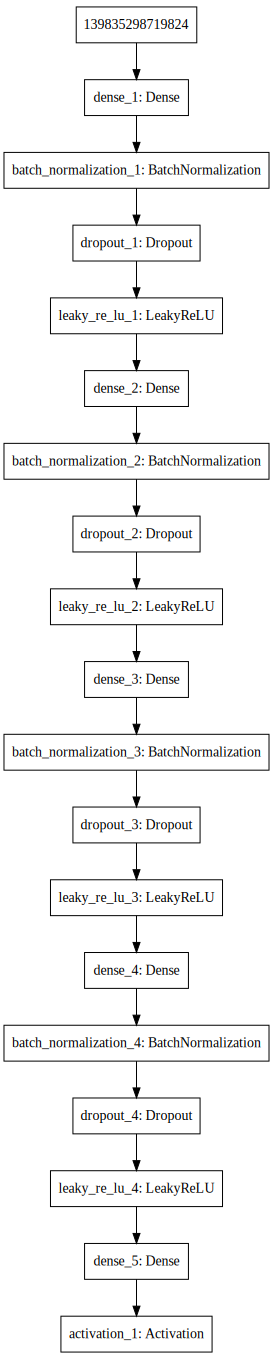

In [13]:
from IPython.display import SVG

img = SVG(model_to_dot(model).create(prog='dot', format='svg'))
img

In [14]:
with open("model_3outputs_relu_13aug2019.png", "wb") as fout:
    fout.write(img.data)

### Let's see the summary of our model and total number of parameters.

In [15]:
#model.build(input_shape=(None, x_train.shape[0], x_train.shape[1]))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              33792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

### Finally, let's train the model. If you use ~5 Million events, it will take a total of 12-20 hours, which for 4 core SWAN notebook will translate into 3-5 hours of actual time. 

In [16]:
# tried epochs=20 and batch-size=256, takes 301 seconds per epoch.
#smaller architecture and only 64 batch takes longer: 471-491 seconds!

#9 epochs if want for peak near 1?

# NOTE: another extremely import parameters:
# 1.epochs (increasing it not always helps), we also have callbacks to stop earlier
# 2.batch_size. Affects the position of the peak! 
# It is how many events to use at a time per update of the weights of the our NN.
# In total, weights will be updated sample_size/batch_size * epochs.
# Higher batch size may (and may not!) be better for a resolution, 
# but lower batch size seem to be better for the main estimate.
# A rule of thumb is 32-512, I tried up to 2048. 
# In the latter case, the peak moved quite a bit. 

%time results= model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=30,batch_size=64,verbose=2, callbacks=[earlyStopping])


W0815 00:58:14.036426 139838305527616 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0815 00:58:15.148210 139838305527616 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 5162880 samples, validate on 1720960 samples
Epoch 1/30
 - 1422s - loss: 0.0616 - mean_squared_error: 1.5181 - mean_absolute_error: 0.0707 - val_loss: 0.0806 - val_mean_squared_error: 24.9374 - val_mean_absolute_error: 0.0808
Epoch 2/30
 - 1350s - loss: 0.0527 - mean_squared_error: 1.3090 - mean_absolute_error: 0.0625 - val_loss: 0.0641 - val_mean_squared_error: 8.2214 - val_mean_absolute_error: 0.0679
Epoch 3/30
 - 1318s - loss: 0.0496 - mean_squared_error: 1.2651 - mean_absolute_error: 0.0603 - val_loss: 0.0678 - val_mean_squared_error: 1.4529 - val_mean_absolute_error: 0.0872
Epoch 4/30
 - 1387s - loss: 0.0482 - mean_squared_error: 1.2253 - mean_absolute_error: 0.0591 - val_loss: 0.0469 - val_mean_squared_error: 1.1266 - val_mean_absolute_error: 0.0540
Epoch 5/30
 - 1378s - loss: 0.0474 - mean_squared_error: 1.2391 - mean_absolute_error: 0.0584 - val_loss: 0.0466 - val_mean_squared_error: 1.3516 - val_mean_absolute_error: 0.0540
Epoch 6/30
 - 1412s - loss: 0.0468 - mean_squ

### Now, let's save the model for later use. This is the part of the EGamma project that is going to be shared with the final user - the user will load the model with its architecture and weights, will give the electron information to the model, and will get an output (estimate and resolution).

In [17]:
from keras.models import load_model
import h5py

model.save('my_model_3outputs_relu_13aug2019.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#loaded_model = load_model('my_model.h5')

#to use the loaded model
#predicted_output = loaded_model.predict(myinput, batch_size=mybatchsize)


### Let's write a function to check how well the model performed on the train and validation tests. One can also pass other metrics here, such as r2_score, etc

In [18]:
def print_out(history):# summarize history for accuracy
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('model mean_absolute_error')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

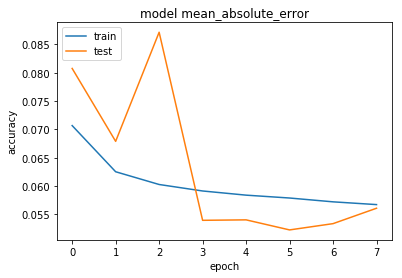

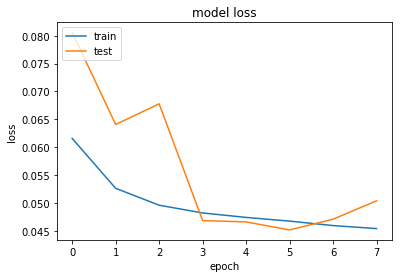

In [19]:
print_out(results)

### Let's get a model prediction on the independent test data set. It can be any data set of a million of event or just a single row with 32 variables corresponding to electron information in a single event.

In [20]:
y_pred = model.predict(x_test)
y_pred

array([[1.0033419 , 0.99792266, 1.0077451 ],
       [1.0680851 , 1.0257409 , 1.0689394 ],
       [1.0282842 , 1.0141557 , 1.0346069 ],
       ...,
       [1.0259305 , 1.0130988 , 1.0336787 ],
       [1.0262883 , 1.0126741 , 1.0339134 ],
       [1.062406  , 1.013764  , 1.0764982 ]], dtype=float32)

### Even though loading the model and predicting results is a matter of less than 1 minute, still, let's store the array of predicted values.

In [21]:
np.save('y_pred_3outputs_relu_13aug2019.npy', y_pred)

### Scatter plot of input (test) vs predicted (based on test) ratios of energies

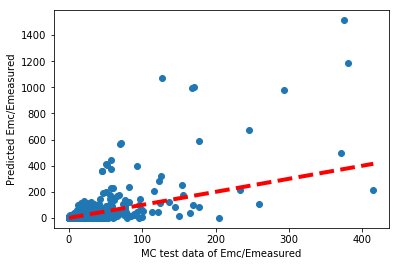

In [22]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred[:,0])
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=4)
ax.set_xlabel('MC test data of Emc/Emeasured')
ax.set_ylabel('Predicted Emc/Emeasured')
plt.show()

### Let's plot variables of interest and compare results. We plot only the estimate. Resolution distributions are plotted in the next cell

/usr/local/bin/start_ipykernel.py:16: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


maxbin_PoT 1.0007253626813406
maxbin_overT 0.9961230615307654


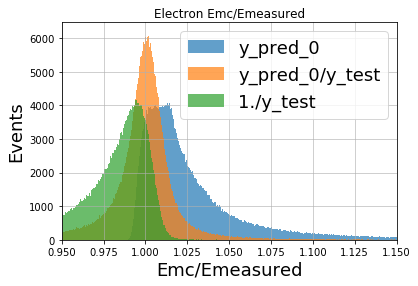

<Figure size 2160x1440 with 0 Axes>

In [23]:
plt.title("Electron Emc/Emeasured")
plot_name = "results_model_3outputs_relu_15aug2019.pdf"
#Add extra 0 for finer binning.
bin_size = 0.0001

min_edge = 0.95; max_edge = 1.15
bins = 20000 

mean = y_test.mean()
std = y_test.std()

xleft = mean - std*1
xright = mean + std*1

#print 'Mean minus std is equal to ', xleft
#print 'Mean plus std is equal to ', xright

N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)
bins= bin_list

plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

plt.xlim((min_edge, max_edge))  # adjust the top leaving bottom unchanged

plt.hist(y_pred[:,0:1], bins, alpha=0.7, label='y_pred_0')
#plt.hist(y_pred[:,1], bins, alpha=0.7, label='y_pred_1')
#plt.hist(y_pred[:,2], bins, alpha=0.7, label='y_pred_2')

# calculation of the peak positions
n_PoT, b_PoT, patches_PoT = plt.hist(y_pred[:,0:1]/y_test, bins, alpha=0.7, label='y_pred_0/y_test')
n_overT, b_overT, patches_overT = plt.hist(1./y_test, bins, alpha=0.7, label='1./y_test')
#plt.hist(ndf.mc_energy, bins, alpha=0.5, label='mc_energy')
#plt.hist(ndf.meas_energy, bins, alpha=0.5, label='meas_energy')
#plt.ylim(top=11000)  # adjust the top leaving bottom unchanged

# Print peak positions.
bin_max_PoT = np.where(n_PoT == n_PoT.max())
print'maxbin_PoT', b_PoT[bin_max_PoT][0]

bin_max_overT = np.where(n_overT == n_overT.max())
print'maxbin_overT', b_overT[bin_max_overT][0]


plt.rcParams["figure.figsize"] = [15,15]
plt.legend(prop={'size': 18}, loc='upper right')
#plot.legend(loc=2, prop={'size': 6})
plt.xlabel("Emc/Emeasured", fontsize=18)
plt.ylabel('Events', fontsize=18)#plt.show()
#fig = plt.figure()

fig = plt.figure( figsize=(20, 20))
fig.set_figheight(20)
fig.set_figwidth(30)

x1 = mean - std
x2 = mean - std
y1 = 0
y2 = 52000
# draw vertical line from (x1,y1) to (x2, y2)
#plt.plot([x1, y1], [x2, y2], 'k-', lw=2)



plt.savefig(plot_name, dpi=400)

### Plot quantiles, a.k.a., the resolution

/usr/local/bin/start_ipykernel.py:16: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


maxbin_PoT 1.0007253626813406
maxbin_overT 0.9961230615307654


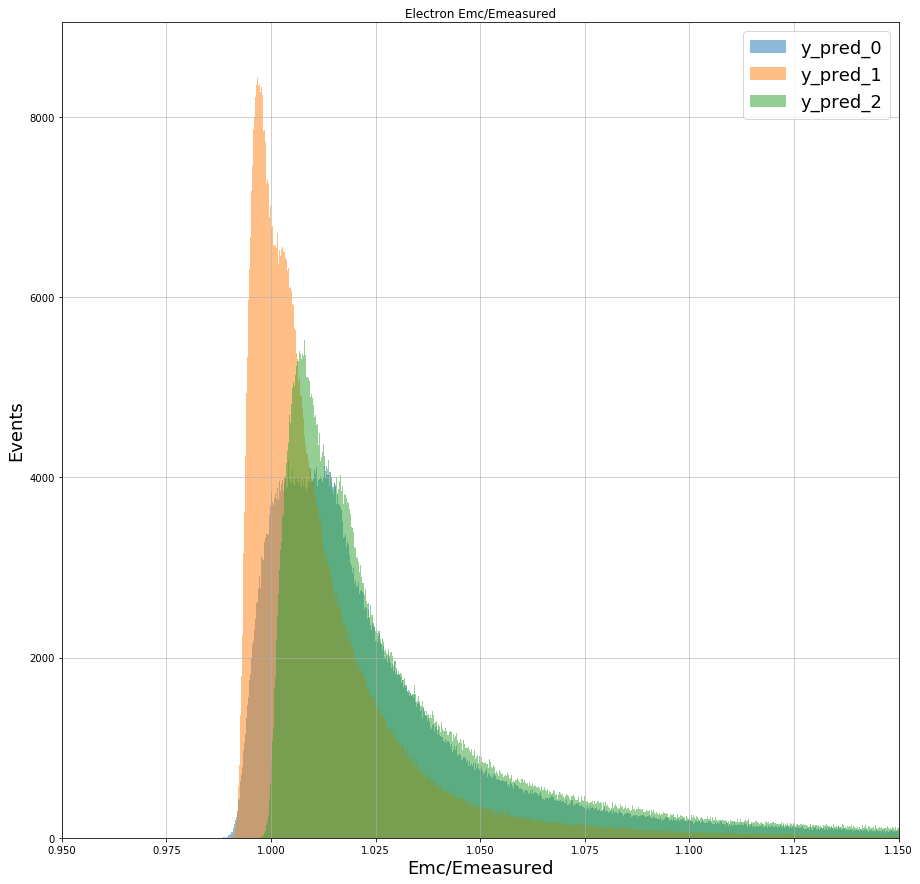

<Figure size 2160x1440 with 0 Axes>

In [24]:
plt.title("Electron Emc/Emeasured")

plot_name = "results_model_3outputs_relu_Only3outputs_15aug2019.pdf"


mean = y_test.mean()
std = y_test.std()

xleft = mean - std*1
xright = mean + std*1

#print 'Mean minus std is equal to ', xleft
#print 'Mean plus std is equal to ', xright

bin_size = 0.0001; 

min_edge = 0.95; max_edge = 1.15
bins = 20000 #np.linspace(0.01, 2000, 1000)
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)
bins= bin_list

plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

plt.xlim((min_edge, max_edge))  # adjust the top leaving bottom unchanged

plt.hist(y_pred[:,0], bins, alpha=0.5, label='y_pred_0')
plt.hist(y_pred[:,1], bins, alpha=0.5, label='y_pred_1')
plt.hist(y_pred[:,2], bins, alpha=0.5, label='y_pred_2')
#n_PoT, b_PoT, patches_PoT = plt.hist(y_pred[:,0:1]/y_test, bins, alpha=0.7, label='y_pred_0/y_test')
#n_overT, b_overT, patches_overT = plt.hist(1./y_test, bins, alpha=0.7, label='1./y_test')
#plt.hist(ndf.mc_energy, bins, alpha=0.5, label='mc_energy')
#plt.hist(ndf.meas_energy, bins, alpha=0.5, label='meas_energy')
#plt.ylim(top=11000)  # adjust the top leaving bottom unchanged


bin_max_PoT = np.where(n_PoT == n_PoT.max())
print'maxbin_PoT', b_PoT[bin_max_PoT][0]

bin_max_overT = np.where(n_overT == n_overT.max())
print'maxbin_overT', b_overT[bin_max_overT][0]


plt.rcParams["figure.figsize"] = [15,15]
plt.legend(prop={'size': 18}, loc='upper right')
#plot.legend(loc=2, prop={'size': 6})
plt.xlabel("Emc/Emeasured", fontsize=18)
plt.ylabel('Events', fontsize=18)#plt.show()
#fig = plt.figure()

fig = plt.figure( figsize=(20, 20))
fig.set_figheight(20)
fig.set_figwidth(30)

x1 = mean - std
x2 = mean - std
y1 = 0
y2 = 52000
# draw vertical line from (x1,y1) to (x2, y2)
#plt.plot([x1, y1], [x2, y2], 'k-', lw=2)



plt.savefig(plot_name, dpi=400)

(1720960,)

### Store a variable equal to y_pred/y_test ratio, since after modifying dtypes, division won't be as easy.


In [ ]:
y_pred0_over_y_test = y_pred[:, 0:1]/y_test
y_pred0 = y_pred[:, 0:1]
y_pred_25 = y_pred[:, 1:2]
y_pred_75 = y_pred[:, 2:3]

## TO store to ROOT format: 
### 1. Set both(two) dtypes fields for each array to float32: y_pred0, y_test, y_pred0_over_y_test
### 2. Run cell with array2root functions below.

In [ ]:
# Let's save results to ROOT format
from root_numpy import array2root

array2root(y_pred0, 'y_pred0.root', 'y_pred0', 'recreate')

array2root(y_pred_25, 'y_pred_25.root', 'y_pred_25', 'recreate')
array2root(y_pred_75, 'y_pred_75.root', 'y_pred_75', 'recreate')

array2root(y_test,  'y_test.root',  'y_test',  'recreate')
array2root(y_pred0_over_y_test, 'y_pred0_over_y_test.root', 'y_pred0_over_y_test', 'recreate')